# Generalized Gaussian Process

Using PyMC3's Latent Gaussian Process implementation
- API: https://docs.pymc.io/api/gp/implementations.html
- Example: https://docs.pymc.io/notebooks/GP-Latent.html

Example data: `boston_medical_center_2020-04-29_to_2020-06-22.csv`
- Column: `hospitalized_total_covid_patients_suspected_and_confirmed_including_icu`

## Goal
Given a series of past daily counts (admissions, census, etc.) $$y_1, y_2, ..., y_T$$

Assuming $T$ is today, want to predict counts $$y_{T+1}, y_{T+2}, ..., y_{T+F}$$ for $F$ days ahead.

## Model

Suppose that $y$ is Poisson distributed over the exponential of a latent Gaussian Process, i.e.,
$$y_t \sim \text{Poisson}( \exp(f_t) )$$

where $f$ is modeled by a Gaussian Process
$$ f_t \sim N(m(t), k(t,t'))$$
with constant mean
$$m(t) = c$$
and squared exponential covariance
$$k(t,t') = a^2 \exp\left(-\frac{(t-t')^2}{2l^2}\right)$$

## Parameters and their Priors

GP mean: $$c \sim \text{TruncatedNormal}(4, 2, \text{low}=0)$$
SqExp cov amplitude: $$a \sim \text{HalfNormal}(\sigma=2)$$
SqExp cov time-scale: $$l \sim \text{TruncatedNormal}(10, 2, \text{low}=0)$$

## Training

Let the subscript "past" represent indices $1$ through $T$, and the subscript "future" represent indices $T+1$ through $T+F$.

1. Specify a Latent GP with the mean and covariance functions defined above.
1. Define a `prior` distribution over all $f$ (i.e., condition on both $t_\text{past}$ and $t_\text{future}$).
1. Define the observed variable $$y_\text{past} \sim \text{Poisson}(\mu = \exp(f_\text{past}))$$ Set `mu` to be the exponential of the first $T$ $f$ values, i.e., only $f_\text{past}$.
1. Use PyMC3's MCMC to draw samples from the posterior $$c^s, a^s, l^s, f^s \sim p(c, a, l, f_\text{past}, f_\text{future} | y_\text{past})$$

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import logging
logger = logging.getLogger('arviz')
logger.setLevel(logging.ERROR)

In [2]:
df = pd.read_csv('../mass_dot_gov_datasets/boston_medical_center_2020-04-29_to_2020-06-22.csv')
y = df['hospitalized_total_covid_patients_suspected_and_confirmed_including_icu'].astype(float)
T = len(y)
F = 7
t = np.arange(T+F)[:,None]

In [3]:
with pm.Model() as model:
    c = pm.TruncatedNormal('mean', mu=4, sigma=2, lower=0)
    mean_func = pm.gp.mean.Constant(c=c)
    
    a = pm.HalfNormal('amplitude', sigma=2)
    l = pm.TruncatedNormal('time-scale', mu=10, sigma=2, lower=0)
    cov_func = a**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    
    f = gp.prior('f', X=t)

    y_past = pm.Poisson('y_past', mu=tt.exp(f[:T]), observed=y)
    y_logp = pm.Deterministic('y_logp', y_past.logpt)

In [4]:
with model:
    trace = pm.sample(5000, tune=1000, target_accept=.99, random_seed=42, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: U

In [5]:
summary = pm.summary(trace)['mean'].to_dict()
for key in ['mean', 'amplitude', 'time-scale']:
    print(key, summary[key])

print('\nTraining score:')
print(np.log(np.mean(np.exp(trace.get_values('y_logp', chains=0)))) / T)

mean 4.692
amplitude 0.657
time-scale 10.762

Training score:
-3.520214954453251


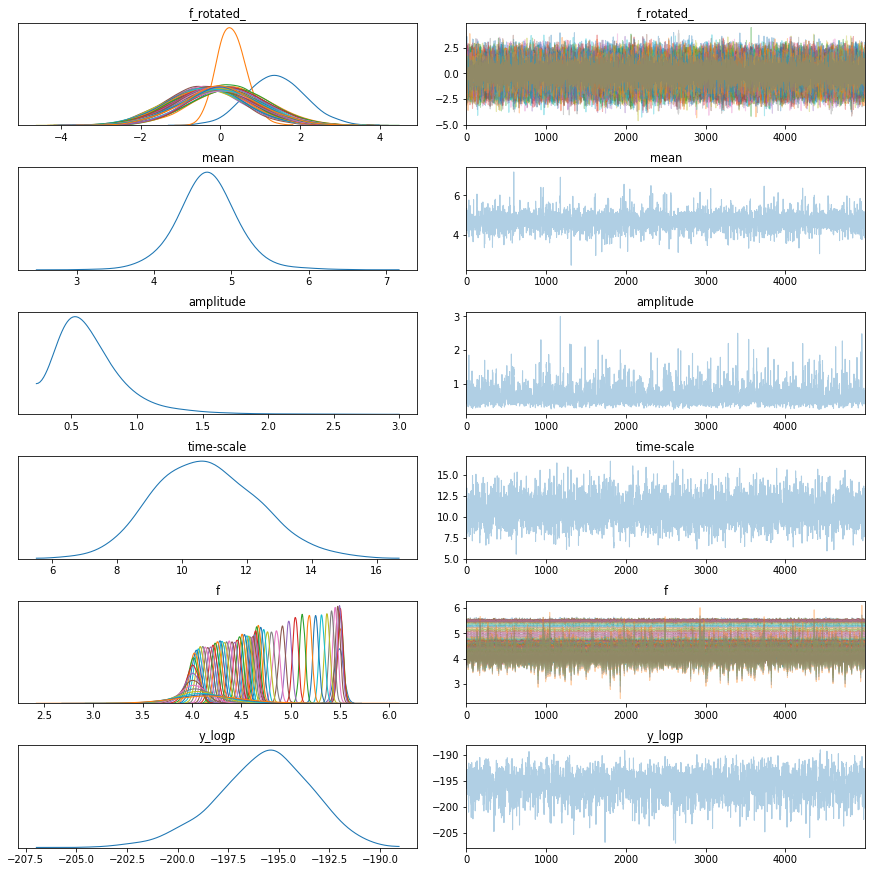

In [6]:
pm.traceplot(trace);

## Forecasting Procedure

1. Define a predictive distribution for future $y$ values $$y_\text{future} \sim \text{Poisson}(\mu = \exp(f_\text{future}))$$
1. Use PyMC3's `sample_posterior_predictive` and the posterior samples collected during training to produce forecasts.

In [7]:
with model:
    y_future = pm.Poisson('y_future', mu=tt.exp(f[-F:]), shape=F)
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_future], random_seed=42)

samples = forecasts['y_future']

100%|██████████| 5000/5000 [00:04<00:00, 1137.83it/s]


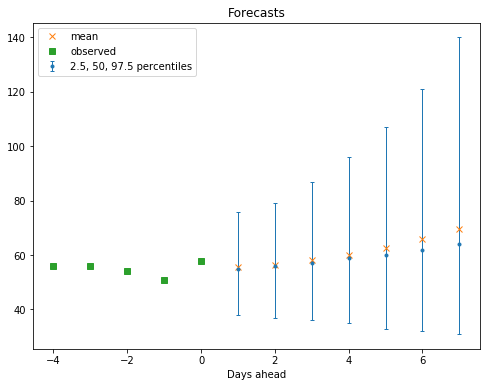

In [8]:
low = np.zeros(F)
high = np.zeros(F)
mean = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)
    mean[i] = np.mean(samples[:,i])

plt.figure(figsize=(8,6))
x_future = np.arange(1,F+1)
plt.errorbar(x_future, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles');
plt.plot(x_future, mean, 'x', label='mean');
x_past = np.arange(-4,1)
plt.plot(x_past, y[-5:], 's', label='observed')
plt.legend();
plt.title('Forecasts');
plt.xlabel('Days ahead');

## Heldout Scoring Procedure

1. Partition the data to treat the first 80% as "past" and the last 20% as "future." We'll use $y_\text{past}$ as the training set, and $y_\text{future}$ as the validation set.
1. Train the model using $y_\text{past}$.
1. Define the predictive distribution $$y_\text{future} \sim \text{Poisson}(\mu = \exp(f_\text{future}))$$ Set `observed` to be the observed $y_\text{future}$ values.
1. Define a `Deterministic` distribution that computes the logp of the observed variable $y_\text{future}$.
1. Use `sample_posterior_predictive` to compute the log probability of $y_\text{future}$ conditioned on each posterior sample {$c^s, a^s, l^s, f^s$}.
1. Use Monte Carlo integration to estimate the log probability of the heldout set: $$\log p(y_\text{future} | y_\text{past}) = \log \frac{1}{S} \sum_{s=1}^S p(y_\text{future} | c^s, a^s, l^s, f^s, y_\text{past})$$

In [2]:
df = pd.read_csv("../mass_dot_gov_datasets/boston_medical_center_2020-04-29_to_2020-06-22.csv")
y = df['hospitalized_total_covid_patients_suspected_and_confirmed_including_icu'].astype(float)

T = int(.8 * len(y))
y_tr = y[:T]
y_va = y[T:]
F = len(y_va)

t = np.arange(T+F)[:,None]

In [3]:
with pm.Model() as model:
    c = pm.TruncatedNormal('mean', mu=4, sigma=2, lower=0)
    mean_func = pm.gp.mean.Constant(c=c)
    
    a = pm.HalfNormal('amplitude', sigma=2)
    l = pm.TruncatedNormal('time-scale', mu=20, sigma=5, lower=0)
    cov_func = a**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    
    f = gp.prior('f', X=t)

    y_past = pm.Poisson('y_past', mu=tt.exp(f[:T]), observed=y_tr)
    y_logp = pm.Deterministic('y_logp', y_past.logpt)

In [4]:
with model:
    trace = pm.sample(5000, tune=1000, chains=1, target_accept=.99, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: U

In [5]:
summary = pm.summary(trace)['mean'].to_dict()
for key in ['mean', 'amplitude', 'time-scale']:
    print(key, summary[key])

print('\nTraining score:')
print(np.log(np.mean(np.exp(trace.get_values('y_logp', chains=0)))) / T)

mean 4.803
amplitude 0.939
time-scale 13.501

Training score:
-3.615676823700355


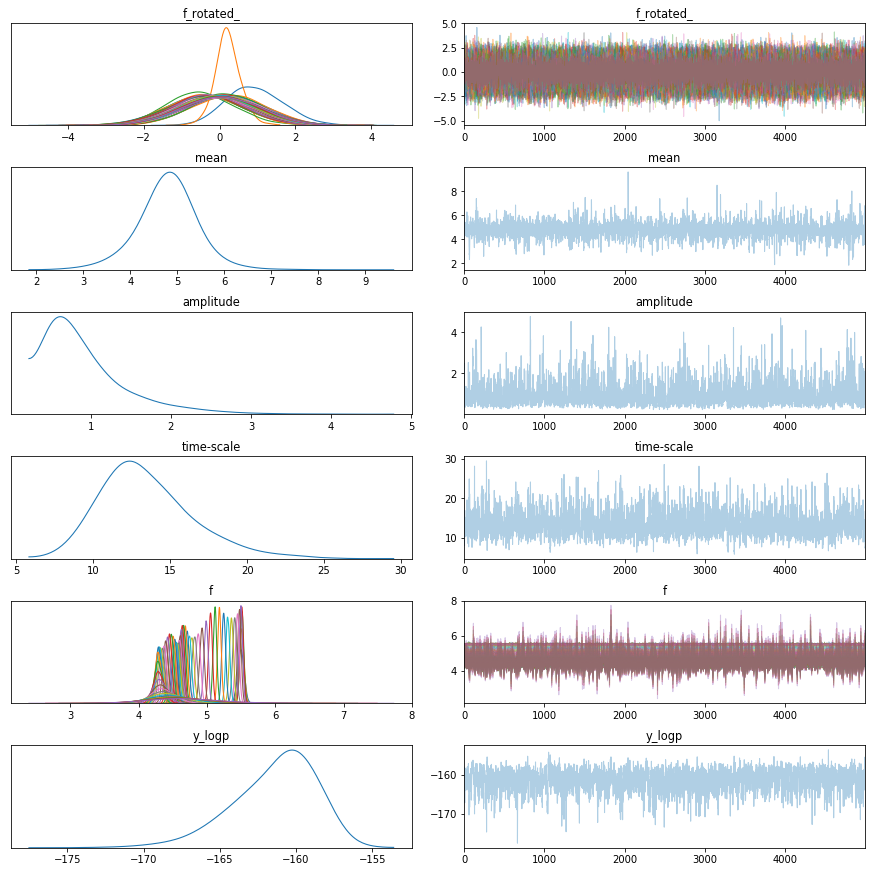

In [6]:
pm.traceplot(trace);

In [7]:
with model:
    y_future = pm.Poisson('y_future', mu=tt.exp(f[-F:]), observed=y_va)
    lik = pm.Deterministic('lik', y_future.logpt)
    logp_list = pm.sample_posterior_predictive(trace, vars=[lik], keep_size=True)

100%|██████████| 5000/5000 [00:06<00:00, 751.25it/s]


In [8]:
print('Heldout score:')
print(np.log(np.mean(np.exp(logp_list['lik'][0]))) / F)

Heldout score:
-3.392338064775352


In [9]:
with model:
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f[T:]), shape=F)
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_pred], random_seed=42)

samples = forecasts['y_pred']

100%|██████████| 5000/5000 [00:04<00:00, 1186.04it/s]


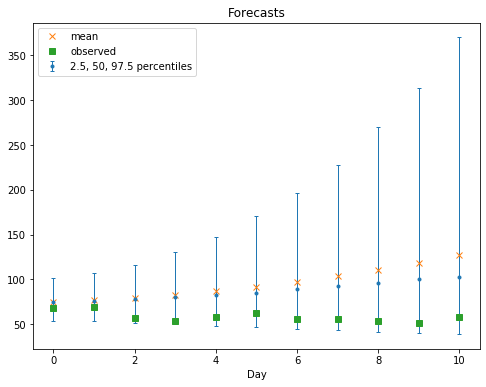

In [10]:
low = np.zeros(F)
high = np.zeros(F)
mean = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)
    mean[i] = np.mean(samples[:,i])

xticks = np.arange(F)
plt.figure(figsize=(8,6))
plt.errorbar(xticks, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles');
plt.plot(xticks, mean, 'x', label='mean');
plt.plot(xticks, y_va, 's', label='observed');
plt.legend();
plt.title('Forecasts');
plt.xlabel('Day');